## 2 Analyzing the Data
### Set up

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

### Data
**Use the data found on Canvas, in ‘proshares analysis data.xlsx’. It has monthly data on financial indexes and ETFs from Aug 2011 through Sep 2021.**

In [4]:
fund_ret = pd.read_excel("../data/proshares_analysis_data.xlsx", sheet_name="hedge_fund_series", index_col=0)
fund_ret.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027035,-0.006489
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032465,-0.022144
2011-10-31,0.026858,0.043593,0.043320,0.050530,0.025241
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028606,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001823


In [189]:
factor_ret = pd.read_excel(
    "../data/proshares_analysis_data.xlsx", sheet_name="merrill_factors", index_col=0)
factor_ret.head()

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2011-08-31,-0.054976,0.000009,-0.092549,-0.087549,-0.005889,-0.088915
2011-09-30,-0.069421,0.000017,-0.179066,-0.108084,0.142180,-0.111504
2011-10-31,0.109148,-0.000013,0.162989,0.096276,-0.069502,0.151010
2011-11-30,-0.004064,0.000000,-0.019724,-0.021763,0.054627,-0.003782
2011-12-31,0.010449,0.000009,-0.042648,-0.021746,0.075581,0.005144


### Functions

In [376]:
def summary_stat(df, annual_factor=12):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["Sharpe Ratio"] = result["mean"]/result["volatility"]
    return result


def cal_moments(df, annual_factor=12, excess=True, style=True):
    '''cal higher moments of assets returns'''
    result = pd.DataFrame(columns=["ret", "vol", "skewness", "kurtosis"])
    result["ret"] = df.mean() * annual_factor
    result["vol"] = df.std() * np.sqrt(annual_factor)
    # you don't neet to annualize higher moments
    result['skewness'] = df.skew()
    result['kurtosis'] = df.kurtosis()
    result['excess kurtosis'] = result['kurtosis'] - 3

    if excess:
        result = result[['ret', 'vol', 'skewness', 'excess kurtosis']].copy()
        if style:
            result = result.style.format(
                {'ret': '{:.2%}', 'vol': '{:.2%}', 'skewness': '{:.2f}', 'excess kurtosis': '{:.2f}'})
        return result
    else:
        result[['ret', 'vol', 'skewness', 'kurtosis']].copy()
        if style:
            result = result.style.format(
                {'ret': '{:.2%}', 'vol': '{:.2%}', 'skewness': '{:.2f}', 'kurtosis': '{:.2f}'})
        return result


def cal_tail(df, quant=0.05, style=True):
    result = pd.DataFrame()
    # you don't neet to annualize higher moments
    var_name = f'VaR ({quant})'
    cvar_name = f'CVaR ({quant})'
    result[var_name] = df.quantile(quant)
    result[cvar_name] = df[df < df.quantile(quant)].mean()
    if style:
        result = result.style.format(
            {var_name: "{:.2%}", cvar_name: "{:.2%}"})
    return result


def cal_series_max_drawdown(series):
    cum_ret = (series + 1).cumprod()
    cum_max = cum_ret.cummax()

    max_ret = (cum_ret - cum_max)/cum_max
    return max_ret


def maximumDrawdown(df):
    cum_returns = (1 + df).cumprod()
    rolling_max = cum_returns.cummax()  # cummax function
    drawdown = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    summary = pd.DataFrame(
        {'Max Drawdown': max_drawdown, 'Bottom': end_date})

    for col in drawdown:
        summary.loc[col, 'Peak'] = (
            rolling_max.loc[:end_date[col], col]).idxmax()
        recovery_period = drawdown.loc[end_date[col]:, col]
        try:
            summary.loc[col,
                        'Recover'] = recovery_period[recovery_period >= 0].index[0]
        except:
            summary.loc[col, 'Recover'] = None

        summary['Peak'] = pd.to_datetime(summary['Peak'])
        summary["Duration (to Bottom)"] = summary['Bottom'] - summary["Peak"]
        summary['Duration (to Recover)'] = summary['Recover'] - summary['Peak']
        summary.style.format({"Max Drawdown": "{:.2%}"})
    return summary


def tailMetrics(returns, quantile=.05, relative=False, mdd=True):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Skewness'] = returns.skew()
    metrics['Excess Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    if relative:
        VaR /= returns.std()
        CVaR /= returns.std()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    if mdd:
        mdd_stats = maximumDrawdown(returns)
        metrics = metrics.join(mdd_stats)

        if relative:
            metrics['Max Drawdown'] /= returns.std()
    return metrics



In [222]:
def get_ols_result(regressor, targets, annualization=12, ignorenan=True):
    result = pd.DataFrame(
        columns=["Market Beta", "Treynor Ratio", "Info Ratio"], index=targets.columns)
    for ind in targets.columns:
        data = pd.merge(
            regressor, targets[[ind]], how="inner", left_index=True, right_index=True)
        X = data[regressor.columns]
        y = data[ind]
        model = LinearRegression().fit(X, y)
        yfit = model.predict(X)
        residuals = y - yfit

        # result.loc[ind, "Alpha"] = model.intercept_ * annualization
        result.loc[ind, "Market Beta"] = model.coef_[0]
        result.loc[ind, "Treynor Ratio"] = (
            y.mean()/model.coef_[0]) * annualization
        result.loc[ind, "Info Ratio"] = (
            model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return result

def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y)
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio
        num_roundoff = 1e-12
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

In [373]:
def reg_factor(target, factors, annual_factor=12, err_std=True, intercept=True):

    col_name = np.insert(factors.columns, 0, "alpha")
    col_name = np.append(col_name, "R-square")
    if err_std:
        col_name = np.append(col_name, "err_std")
    result = pd.DataFrame(columns=col_name, index=target.columns)

    for ind in target.columns:
        y = target[ind]
        X = factors
        if intercept:
            model = LinearRegression().fit(X, y)


            yfit = model.predict(X)
            residuals = y - yfit

            _paras = np.insert(model.coef_, 0, model.intercept_ * annual_factor)
            score = model.score(X, y)
            _paras = np.append(_paras, score)
        else:
            model = LinearRegression(fit_intercept=False)
            model = model.fit(X, y)
            score = model.score(X, y)
            yfit = model.predict(X)
            residuals = y - yfit

            _paras = np.insert(model.coef_, 0, np.nan)
            _paras = np.append(_paras, score)

        if err_std:
            res_std = residuals.std() * np.sqrt(annual_factor)
            _paras = np.append(_paras, res_std)

        result.loc[ind, :] = _paras
    return result

In [367]:
def rolling_estimation(target, factors, breakpoint, intercept=True):
    length = target.shape[0]

    result = target.iloc[breakpoint:, :].copy()
    y_hat = []
    for i in range(breakpoint, length):
        y = target.iloc[i-breakpoint:i, :]
        X = factors.iloc[i-breakpoint:i, :]

        if intercept:

            model = LinearRegression().fit(X, y)
            _paras = _paras = np.insert(model.coef_, 0, model.intercept_)

            x_tilde = factors.values[i, :]
            y_fit = np.sum(_paras * np.insert(x_tilde, 0, 1))
        
        else:
            model = LinearRegression(fit_intercept=False)
            model = model.fit(X, y)
            y_fit = np.sum(model.coef_ * factors.values[i, :])

        y_hat.append(y_fit)
    col_name = target.columns[0] + "_predict"
    result.loc[:, col_name] = y_hat
    return result


### Constant

In [115]:
annual_factor = 12
num_round = 2

### 1. For the series in the “hedge fund series” tab, report the following summary statistics:
1. mean
2. volatility
3. Sharpe ratio

In [169]:
summary_stat(fund_ret, annual_factor)

,mean,volatility,Sharpe Ratio
HFRIFWI Index,0.042867,0.060912,0.703758
MLEIFCTR Index,0.025665,0.056867,0.451308
MLEIFCTX Index,0.024278,0.056685,0.428294
HDG US Equity,0.014007,0.059239,0.236455
QAI US Equity,0.011576,0.048915,0.236649


### 2. For the series in the “hedge fund series” tab,  calculate the following statistics related to tail- risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown-include the dates of the max/min/recovery within the max drawdown period.

In [377]:
tailMetrics(fund_ret)

,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Bottom,Peak,Recover,Duration (to Bottom),Duration (to Recover)
HFRIFWI Index,-1.020683,6.163102,-0.025585,-0.039205,-0.115473,2020-03-31,2019-12-31,2020-08-31,91 days,244 days
MLEIFCTR Index,-0.315513,1.778696,-0.029652,-0.036865,-0.124302,2022-09-30,2021-06-30,NaT,457 days,NaT
MLEIFCTX Index,-0.304807,1.741807,-0.029867,-0.036763,-0.124388,2022-09-30,2021-06-30,NaT,457 days,NaT
HDG US Equity,-0.298573,1.931106,-0.031528,-0.038482,-0.140720,2022-09-30,2021-06-30,NaT,457 days,NaT
QAI US Equity,-0.634129,1.913339,-0.021245,-0.034401,-0.137714,2022-09-30,2021-06-30,NaT,457 days,NaT



### 3. For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics:

* (a) Market Beta 
* (b) Treynor Ratio

$$\text{Treynor Ratio} \equiv \frac{\tilde\mu}{\beta}$$

* (c) Information ratio

$$\text{Information Ratio} \equiv \frac{\alpha}{\sigma_\epsilon}$$

Annualize these three statistics as appropriate.


In [221]:
get_ols_result(factor_ret[["SPY US Equity"]], fund_ret, annualization=12)

,Market Beta,Treynor Ratio,Info Ratio
HFRIFWI Index,0.349957,0.122493,0.012954
MLEIFCTR Index,0.354876,0.07232,-0.731515
MLEIFCTX Index,0.353605,0.068658,-0.784565
HDG US Equity,0.363099,0.038577,-1.123684
QAI US Equity,0.291895,0.039657,-0.983817


### 4. Relative Performance
Discuss the previous statistics, and what they tell us about...
* (a) the differences between SPY and the hedge-fund series? 

    * SPY has been a rocket during this time, Hedge-funds (as measured by these broad indexes) have underperformed.
    * Given that they have some SPY beta, their total return is positive (Sharpe is positive) but when we strip this factor out, the hedged performance has a negative Sharpe ratio as seen by the Info Ratio (which is the Sharpe Ratio of the hedged position.)
    * HFRI is much less volatile and a much lower trend.
    * But maybe the scaling here is hiding how similar they are. Let's re-plot them, adjusting the scales. And we see they are *very* similar!


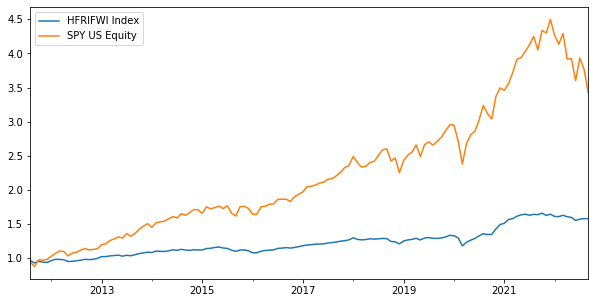

In [249]:
pair = pd.merge(fund_ret["HFRIFWI Index"], factor_ret["SPY US Equity"], how="inner", left_index=True, right_index=True)
pair_cumprod = (pair + 1).cumprod()
pair_cumprod.plot(figsize=(10, 5))

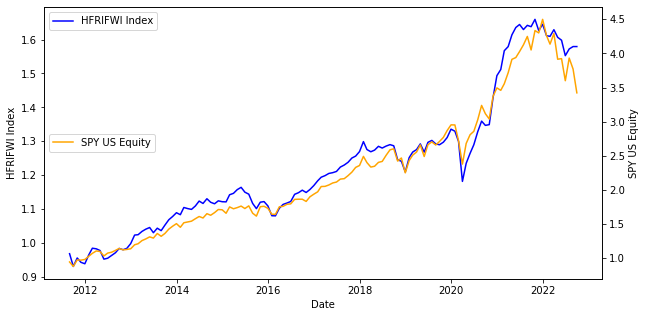

In [250]:
# scaled plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel(pair_cumprod.columns[0])
ax1.plot(pair_cumprod.index,
         pair_cumprod.iloc[:, 0], color='b', label=pair_cumprod.columns[0])

ax2 = ax1.twinx()
ax2.set_ylabel(pair_cumprod.columns[1])
ax2.plot(pair_cumprod.index,
         pair_cumprod.iloc[:, 1], color='orange', label=pair_cumprod.columns[1])

ax1.legend(loc='upper left')
ax2.legend(loc='center left')
plt.show()


(a) the differences between SPY and the hedge-fund series? 
**Solution:**
The SPY has a higher mean, volatility, and Sharpe Ratio than that of all hedge-fund series. Also, the SPY has higher tail risks in terms of VaR, and CVaR. Besides, all hedge-fund series have a negative information ratio, which indicates that they fail to beat the market. 
****
(b) which performs better between HDG and QAI.

**Solution:**
Although HDG has a slightly higher mean return, it also has a higher volatility, so it has a smaller Sharpe Ratio than QAI. In addition, HDG contains more tail risks as it has higher VaR, CVaR, and Maximum Drawdown. The recovery period of HDG is also longer than that of QAI. QAI is also less correlated to the market(See the heat map below), and has a higher Treynor Ratio and Information Ratio. Overall, QAI performs better than HDG. 
****
(c) whether HDG and the ML series capture the most notable properties of HFRI.

**Solution:**
Both HDG and the ML series fail to deliver the same high returns compendated with the high risk of HRFI. The HFRI also shows a very high excess kurtosis, but all of the hedge-fund series has a very small excess kurtosis. 

In [242]:
matrix = get_ols_metrics(
    factor_ret[["SPY US Equity"]], fund_ret, annualization=12)
compare_data = matrix.loc[["HDG US Equity", "QAI US Equity"], ]
compare_data

,alpha,SPY US Equity,r-squared,Treynor Ratio,Info Ratio
HDG US Equity,-0.030021,0.363099,0.796597,0.038577,-1.123684
QAI US Equity,-0.023819,0.291895,0.755027,0.039657,-0.983817


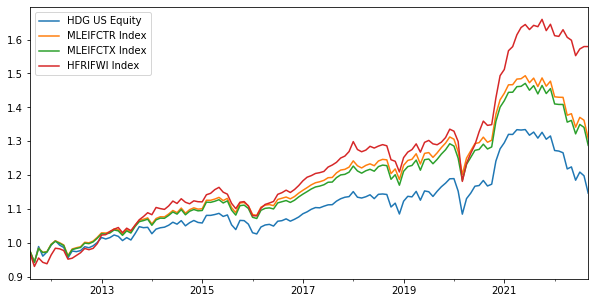

In [251]:
properties_data = fund_ret[["HDG US Equity",
                            "MLEIFCTR Index", "MLEIFCTX Index", "HFRIFWI Index"]]
properties_data = (properties_data + 1).cumprod()
properties_data.plot(figsize=(10, 5))

In [259]:
properties_data.corr().round(4)

,HDG US Equity,MLEIFCTR Index,MLEIFCTX Index,HFRIFWI Index
HDG US Equity,1.0000,0.9920,0.9936,0.9717
MLEIFCTR Index,0.9920,1.0000,0.9999,0.9812
MLEIFCTX Index,0.9936,0.9999,1.0000,0.9824
HFRIFWI Index,0.9717,0.9812,0.9824,1.0000


In [267]:
# run regression
y = properties_data["HFRIFWI Index"]
X = properties_data[["HDG US Equity", "MLEIFCTR Index", "MLEIFCTX Index"]]
X = sm.add_constant(X)

static_model = sm.OLS(y, X).fit()
static_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          HFRIFWI Index   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3235.
Date:                Sun, 09 Oct 2022   Prob (F-statistic):          6.78e-122
Time:                        22:34:39   Log-Likelihood:                 316.28
No. Observations:                 134   AIC:                            -624.6
Df Residuals:                     130   BIC:                            -613.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1956      0.056     -3.481      0.001      -0.307      -0.084
HDG US Equity     -3.6471      0.278    -13.126      0.000      -4.197      -3.097
MLEIFCTR Index   -17.3633      1.234    -14.068      0.000     -19.805     -14.921
MLEIFCTX Index    22.1941      1.447     15.333      0.000      19.331      25.058
==============================================================================
Omnibus:                       22.617   Durbin-Watson:                   0.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.428
Skew:                          -0.645   Prob(JB):                     1.52e-12
Kurtosis:                       5.843   Cond. No.                     2.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


### 5. Report the correlation matrix for these assets.
* (a) Show the correlations as a heat map.
* (b) Which series have the highest and lowest correlations?
    - **QAI** and **HFRI** pair has the lowest correlation, and **HDG** and both 2 **ML series** have the highest correlation. 

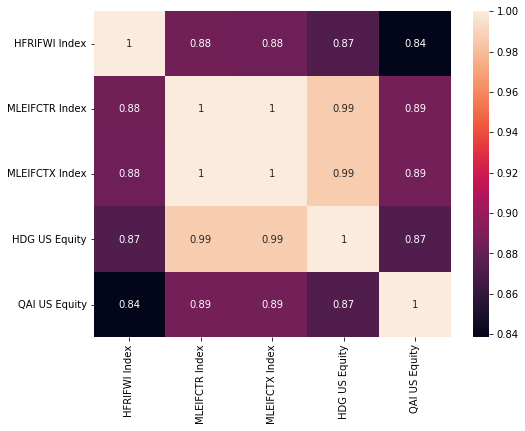

In [262]:
corr_matrix = fund_ret.corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True)

### 6. Replicate HFRI with the six factors listed on the “merrill factors” tab. Include a constant, and run the unrestricted regression

$$r^{hfri}_t = α^{merr} + x^{merr}_tβ^{merr} + ε^{merr}$$
$$\hat r^{hfri}_t \equiv \hat \alpha^{merr} + x^{merr}_t\hat \beta^{merr}$$

Note that the second equation is just our notation for the fitted replication.

* (a) Report the intercept and betas.


In [290]:
reg_factor(fund_ret[["HFRIFWI Index"]], factor_ret, annual_factor=12, err_std=True)

,alpha,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,R-square,err_std
HFRIFWI Index,0.013703,0.025589,0.834569,0.074135,0.105604,0.02324,0.147375,0.821278,0.025751


* (b) Are the betas realistic position sizes, or do they require huge long-short positions?
    - Yes, they are realistic position sizes, all betas are smaller than 1 and do not require huge long-short positions.
****
* (c) Report the R-squared.
    - R-sqaured is reported above 0.82.
****
* (d) Report the volatility of $ε^{merr}$, (the tracking error.)
    - the volatiliy of $ε^{merr}$ is 0.0258
****

### 7. Let’s examine the replication out-of-sample.
Starting with t = 61 month of the sample, do the following:
* Use the previous 60 months of data to estimate the regression equation. This gives time-t estimates of the regression parameters, $\tilde α_t^{merr}$ and $\tilde β_t^{merr}$
* Use the estimated regression parameters, along with the time-t regressor values, xmerr, to t
calculate the time-t replication value4 that is, with respect to the regression estimate, built “out-of-sample” (OOS).
$$\tilde r_t^{hfri} \equiv \tilde \alpha_t^{merr} + (x_t^{merr})' \beta_t^{merr}$$
* Step forward to t = 62, and now use t = 2 through t = 61 for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

In [328]:
from statsmodels.regression.rolling import RollingOLS
y = fund_ret[["HFRIFWI Index"]]
X = sm.add_constant(factor_ret)
model = RollingOLS(y, X, window=60)
rolling_betas = model.fit().params.copy()
rolling_betas

/Users/zhangzixin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2011-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-05-31,0.004084,0.014981,-2.033076,0.108451,0.115181,0.033973,0.175357
2022-06-30,0.004204,0.011314,-2.009264,0.106422,0.111324,0.028605,0.181174
2022-07-31,0.004532,0.001035,-2.399443,0.118317,0.107350,0.020165,0.176503
2022-08-31,0.004210,-0.001067,-1.796845,0.128498,0.076688,0.018624,0.189947


In [335]:
# rep_IS = (rolling_betas * X).sum(axis=1, skipna=False)
rep_OOS = (rolling_betas.shift() * X).sum(axis=1, skipna=False)

In [348]:
replication = fund_ret[['HFRIFWI Index']].copy()
# replication['Static-IS-Int'] = static_model.fittedvalues
# replication['Rolling-IS-Int'] = rep_IS
replication['Rolling-OOS-Int'] = rep_OOS

replication = replication.iloc[60:, :].copy()
replication

,HFRIFWI Index,Rolling-OOS-Int
2016-08-31,0.004274,0.004966
2016-09-30,0.006468,0.005001
2016-10-31,-0.005947,-0.004449
2016-11-30,0.007660,0.011651
2016-12-31,0.010063,0.007650
...,...,...
2022-05-31,-0.005374,0.004892
2022-06-30,-0.028522,-0.028555
2022-07-31,0.012747,0.027382
2022-08-31,0.004520,-0.012255


In [351]:
replication.corr()

,HFRIFWI Index,Rolling-OOS-Int
HFRIFWI Index,1.000000,0.887358
Rolling-OOS-Int,0.887358,1.000000


In [360]:
predict_data = rolling_estimation(fund_ret[["HFRIFWI Index"]], factor_ret, 60)

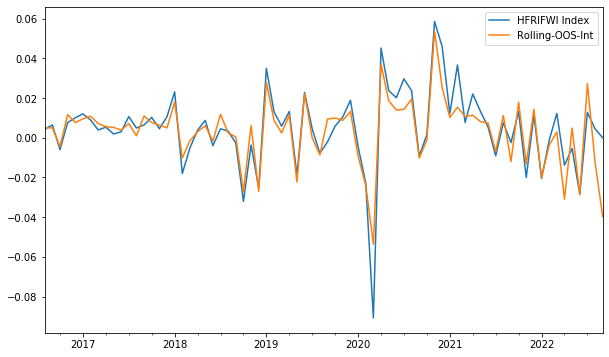

In [364]:
replication.plot(figsize=(10, 6))

### 8. We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.
Report
* (a) the regression beta. How does it compare to the estimated beta with an intercept, $β^{merr}$?

In [374]:
reg1 = reg_factor(fund_ret[["HFRIFWI Index"]], factor_ret, annual_factor=12, err_std=True, intercept=True)
reg2 = reg_factor(fund_ret[["HFRIFWI Index"]], factor_ret,
                  annual_factor=12, err_std=True, intercept=False)
pd.concat([reg1, reg2])

,alpha,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity,R-square,err_std
HFRIFWI Index,0.013703,0.025589,0.834569,0.074135,0.105604,0.02324,0.147375,0.821278,0.025751
HFRIFWI Index,NaN,0.040448,1.551706,0.073052,0.10076,0.024909,0.144352,0.818849,0.025826


In [375]:
data = factor_ret.corr()

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
SPY US Equity,1.000000,-0.128683,0.713358,0.873019,-0.356072,0.886302
USGG3M Index,-0.128683,1.000000,-0.082170,-0.126771,0.090467,-0.112243
EEM US Equity,0.713358,-0.082170,1.000000,0.834555,-0.581697,0.690940
EFA US Equity,0.873019,-0.126771,0.834555,1.000000,-0.532382,0.804649
EUO US Equity,-0.356072,0.090467,-0.581697,-0.532382,1.000000,-0.294335
IWM US Equity,0.886302,-0.112243,0.690940,0.804649,-0.294335,1.000000


* (b) the mean of the fitted value, $r_t^{hfri}$ . How does it compare to the mean of the HFRI?
    - lower than the mean of the HFRI real, also lower than the prediction with an intercept

In [319]:
predict_data.mean()

HFRIFWI Index            0.004581
HFRIFWI Index_predict    0.002979
dtype: float64

In [318]:
predict_data_no_alpha = rolling_estimation(fund_ret[["HFRIFWI Index"]], factor_ret, 60, intercept=False)
predict_data_no_alpha.mean()

HFRIFWI Index            0.004581
HFRIFWI Index_predict    0.002795
dtype: float64

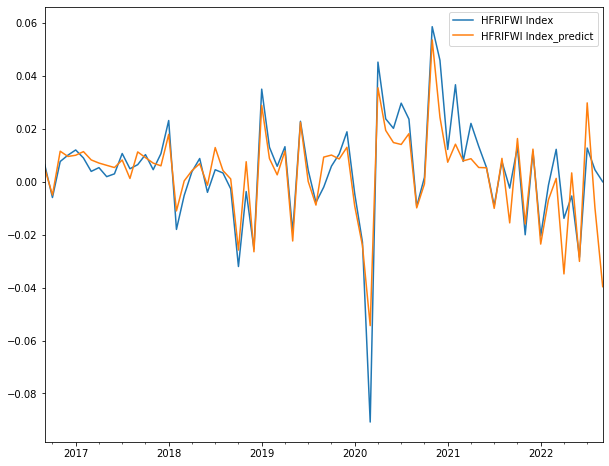

In [313]:
predict_data_no_alpha.plot(figsize=(10, 8))

* (c) the correlations of the fitted values, $r_t^{hfri}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept
    - The prediction with an intercept has a higher correlation than that without an inercept

In [359]:
predict_data.corr()

,HFRIFWI Index,HFRIFWI Index_predict
HFRIFWI Index,1.000000,0.887358
HFRIFWI Index_predict,0.887358,1.000000


In [315]:
predict_data_no_alpha.corr()

,HFRIFWI Index,HFRIFWI Index_predict
HFRIFWI Index,1.000000,0.879878
HFRIFWI Index_predict,0.879878,1.000000
